Last post I described how I collected implicit feedback data from the website [Sketchfab](https://sketchfab.com/). I then claimed I would write about how to actually build a recommendation system with this data. Well, here we are! Let's build.

I think the best place to start when looking into implicit feedback recommenders is with the model outlined in the classic paper "[Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf)" by Koren et.al. (warning: pdf link).  I have seen many names in the literature and machine learning libraries for this model. I'll call it Weighted Regularized Matrix Factorization (WRMF) which tends to be a name used fairly often. WRMF is like the classic rock of implicit matrix factorization. It may not be the trendiest, but it will never go out of style. And, everytime I use it, I know that I'm guaranteed to like what I get out. Specifically, this model makes reasonable intuitive sense, it's scalable, and, most importantly, I've found it easy to tune. There are much fewer hyperparameters than, say, stochastic gradient descent models.

If you recall from my post on [Explicit Feedback Matrix Factorization]({filename}/2016-01-09-explicit-matrix-factorization-als-sgd.md), we had a loss function (without biases) that looked like:

$$L_{exp} = \sum\limits_{u,i \in S}(r_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i})^{2} + \lambda_{x} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{y} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

where $r_{ui}$ is an element of the matrix of user-item *ratings*, $\textbf{x}_{u}$ ($\textbf{y}_{i}$) are user $u$'s (item $i$'s) latent factors, and $S$ was the set of all user-item ratings. WRMF is simply a modification of this loss function:

$$L_{WRMF} = \sum\limits_{u,i}c_{ui} \big( p_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i} \big) ^{2} + \lambda_{x} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{y} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

Here, we are not summing of over elements of $S$ but instead over our entire matrix. Recall that with implicit feedback, we do not have ratings anymore; rather, we have users' preferences for items. In the WRMF loss function, the ratings matrix $r_{ui}$ has been replaced with a preference matrix $p_{ui}$. We make the assumption that if a user has interacted at all with an item, then $p_{ui} = 1$. Otherwise, $p_{ui} = 0$.

The other new term in the loss function is $c_{ui}$. We call this the confidence matrix, and it roughly describes how confident we are that user $u$ does in fact have preference $p_{ui}$ for item $i$. In the paper, one of the confidence formulas that the authors consider is linear in the number of interactions. If we take $d_{ui}$ to be the number of times a user has clicked on an item on a website, then

$$c_{ui} = 1 + \alpha d_{ui}$$

where $\alpha$ is some hyperparameter determined by cross validation. In the case of the Sketchfab data, we only have binary "likes", so $d_{ui} \in \{0, 1\}$

To take a step back, WRMF does not make the assumption that a user who has not interacted with an item does not *like* the item. WRMF *does* assume that that user has a negative preference towards that item, but we can choose how confident we are in that assumption through the confidence hyperparameter.

Now, I could go through the whole derivation in gory latex of how to optimize this algorithm &aacute; la my previous explicit MF post, but other people have already done this many times over. Here's a great StackOverflow [answer](http://math.stackexchange.com/a/1073170), or, if you like your derivations in Dirac notation, then checkout Sudeep Das' [post](http://datamusing.info/blog/2015/01/07/implicit-feedback-and-collaborative-filtering/).

## WRMF Libraries

There are a number of places to find open source code which implements WRMF. The most popular method of optimizing the loss function is through Alternating Least Squares. This tends be less tricky to tune than stochastic gradient descent, and the model is [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel). 

The first code I saw for this algorithm was from Chris Johnson's [repo](https://github.com/MrChrisJohnson/implicit-mf). This code is in python, nicely makes use of sparse matrices, and generally gets the job done. Thierry Bertin-Mahieux then took this code and [parallelized it](https://github.com/tbertinmahieux/implicit-mf) using the python multiprocessing library. This provides a decent speedup with no loss in accuracy. 

The people at Quora came out with a library called [qmf](https://github.com/quora/qmf) which is parellized and written in C++. I haven't used it, but it is presumably faster than the multiprocessing python version. Lastly, Ben Frederickson went and wrote parallelized code in pure Cython [here](https://github.com/benfred/implicit). This blows the other python versions out of the water in terms of performance and is somehow [faster](https://github.com/benfred/implicit/blob/master/examples/benchmark.py) than qmf (which seems odd).

Anywho, I ended up using Ben's library for this post because (1) I could stay in python, and (2) it's super fast. I forked the library and wrote a small class to wrap the algorithm to make it easy to run grid searches and calculate learning curves. Feel free to check out my fork [here](https://github.com/EthanRosenthal/implicit), though I didn't write any tests so use at your own risk :)

## Massaging the data

Now that that's out of the way, let's train a WRMF model so we can finally recommend some Sketchfab models!

The first step is to load the data and transform it into an interactions matrix of size "number of users" by "number of items". The data is currently stored as a csv with each row denoting a model that a user has "liked" on the Sketchfab website. The first column is the name of the model, the second column is the unique model ID (```mid```), and the third column is the anonymized user ID (```uid```).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import pickle
import csv
import implicit
import itertools
import copy
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../data/model_likes_anon.psv',
                 sep='|', quoting=csv.QUOTE_MINIMAL,
                 quotechar='\\')
df.head()

,modelname,mid,uid
0,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,7ac1b40648fff523d7220a5d07b04d9b
1,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,2b4ad286afe3369d39f1bb7aa2528bc7
2,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1bf0993ebab175a896ac8003bed91b4b
3,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,6484211de8b9a023a7d9ab1641d22e7c
4,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1109ee298494fbd192e27878432c718a


In [3]:
print('Duplicated rows: ' + str(df.duplicated().sum()))
print('That\'s weird - let\'s just drop them')
df.drop_duplicates(inplace=True)

Duplicated rows 155
That's weird - let's just drop them


In [4]:
df = df[['uid', 'mid']]
df.head()

,uid,mid
0,7ac1b40648fff523d7220a5d07b04d9b,5dcebcfaedbd4e7b8a27bd1ae55f1ac3
1,2b4ad286afe3369d39f1bb7aa2528bc7,5dcebcfaedbd4e7b8a27bd1ae55f1ac3
2,1bf0993ebab175a896ac8003bed91b4b,5dcebcfaedbd4e7b8a27bd1ae55f1ac3
3,6484211de8b9a023a7d9ab1641d22e7c,5dcebcfaedbd4e7b8a27bd1ae55f1ac3
4,1109ee298494fbd192e27878432c718a,5dcebcfaedbd4e7b8a27bd1ae55f1ac3


In [5]:
n_users = df.uid.unique().shape[0]
n_items = df.mid.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(df.shape[0]) / float(n_users*n_items) * 100))

Number of users: 62583
Number of models: 28806
Sparsity: 0.035%


While implicit recommendations excel where data is sparse, it can often be helpful to make the interactions matrix a little more dense. We limited our data collection to models that had at least 5 likes. However, it may not be the case that every user has liked at least 5 models. Let's go ahead and knock out users that liked fewer than 5 models. This could possibly mean that some models end up with fewer than 5 likes once these users are knocked out, so we will have to alternate back and forth knocking users and models out until things stabilize.

In [6]:
def threshold_likes(df, uid_min, mid_min):
    n_users = df.uid.unique().shape[0]
    n_items = df.mid.unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Starting likes info')
    print('Number of users: {}'.format(n_users))
    print('Number of models: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done = False
    while not done:
        starting_shape = df.shape[0]
        mid_counts = df.groupby('uid').mid.count()
        df = df[~df.uid.isin(mid_counts[mid_counts < mid_min].index.tolist())]
        uid_counts = df.groupby('mid').uid.count()
        df = df[~df.mid.isin(uid_counts[uid_counts < uid_min].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True
    
    assert(df.groupby('uid').mid.count().min() >= mid_min)
    assert(df.groupby('mid').uid.count().min() >= uid_min)
    
    n_users = df.uid.unique().shape[0]
    n_items = df.mid.unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Ending likes info')
    print('Number of users: {}'.format(n_users))
    print('Number of models: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [7]:
df_lim = threshold_likes(df, 5, 5)

Starting likes info
Number of users: 62583
Number of models: 28806
Sparsity: 0.035%
Ending likes info
Number of users: 15274
Number of models: 25655
Sparsity: 0.140%


Nice, we're above 0.1% which should be suitable for making decent recommendations. We now need to map each ```uid``` and ```mid``` to a row and column, respectively, for our interactions, or "likes" matrix. This can be done simply with Python dictionaries

In [8]:
# Create mappings
mid_to_idx = {}
idx_to_mid = {}
for (idx, mid) in enumerate(df_lim.mid.unique().tolist()):
    mid_to_idx[mid] = idx
    idx_to_mid[idx] = mid
    
uid_to_idx = {}
idx_to_uid = {}
for (idx, uid) in enumerate(df_lim.uid.unique().tolist()):
    uid_to_idx[uid] = idx
    idx_to_uid[idx] = uid

The last step is to actually build the matrix. We will use sparse matrices so as not to take up too much memory. Sparse matrices are tricky because they come in many forms, and there are giant performance tradeoffs between them. Below is a super slow way to build a likes matrix. I tried running ```%%timeit``` but got bored waiting for it to finish.

In [9]:
# # Don't do this!
# num_users = df_lim.uid.unique().shape[0]
# num_items = df_lim.mid.unique().shape[0]
# likes = sparse.csr_matrix((num_users, num_items), dtype=np.float64)
# for row in df_lim.itertuples():
#     likes[uid_to_idx[uid], mid_to_idx[row.mid]] = 1.0

Alternatively, the below is pretty damn fast considering we're building a matrix of half a million likes.

In [10]:
def map_ids(row, mapper):
    return mapper[row]

In [11]:
%%timeit
I = df_lim.uid.apply(map_ids, args=[uid_to_idx]).as_matrix()
J = df_lim.mid.apply(map_ids, args=[mid_to_idx]).as_matrix()
V = np.ones(I.shape[0])
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

1 loop, best of 3: 876 ms per loop


In [12]:
I = df_lim.uid.apply(map_ids, args=[uid_to_idx]).as_matrix()
J = df_lim.mid.apply(map_ids, args=[mid_to_idx]).as_matrix()
V = np.ones(I.shape[0])
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

## Cross-validation: Splitsville

Okay, we got a likes matrix and need to split it into training and test matrices. I do this a bit trickily (which is maybe a word?). I would like to track precision@k as my optimization metric later. A k of 5 would be nice. However, if I move 5 items from training to test for some of the users, then they may not have any data left in the training set (remember they had a minimum 5 likes). Thus, the train_test_split only looks for people who have at least 2*k (10 in this case) likes before moving some of their data to the test set. This obviously biases our cross-validation towards users with more likes. So it goes.

In [13]:
def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*k, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=False)
        train[user, test_ratings] = 0.
        # These are just 1.0 right now
        test[user, test_ratings] = ratings[user, test_ratings]
   
    
    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [14]:
train, test, user_index = train_test_split(likes, 5, fraction=0.2)

## Cross-validation: Grid search

Now that the data is split into training and test matrices, let's run a giant grid search to optimize our hyperparameters. We have four parameters that we would like to optimize:

1. ```num_factors```: The number of latent factors, or degree of dimensionality in our model.
2. ```regularization```: Scale of regularization for both user and item factors.
3. ```alpha```: Our confidence scaling term.
3. ```iterations```: Number of iterations to run Alternating Least Squares optimization.

I am going to track mean squared error (MSE) and precision at k (p@k), but I mainly care about the later. I've written some functions below to help with metric calculations and making the training log printout look nice. I am going to calculate a bunch of learning curves (that is, evaluate performance metrics at various stages of the training process) for a bunch of different hyperparameter combinations. Props to scikit-learn for being open source and letting me basically crib their GridSearchCV code.

In [15]:
from sklearn.metrics import mean_squared_error
def calculate_mse(model, ratings, user_index=None):
    preds = model.predict_for_customers()
    if user_index:
        return mean_squared_error(ratings[user_index, :].toarray().ravel(),
                                  preds[user_index, :].ravel())
    
    return mean_squared_error(ratings.toarray().ravel(),
                              preds.ravel())

In [16]:
def precision_at_k(model, ratings, k=5, user_index=None):
    if not user_index:
        user_index = range(ratings.shape[0])
    ratings = ratings.tocsr()
    precisions = []
    # Note: line below may become infeasible for large datasets.
    predictions = model.predict_for_customers()
    for user in user_index:
        # In case of large dataset, compute predictions row-by-row like below
        # predictions = np.array([model.predict(row, i) for i in xrange(ratings.shape[1])])
        top_k = np.argsort(-predictions[user, :])[:k]
        labels = ratings.getrow(user).indices
        precision = float(len(set(top_k) & set(labels))) / float(k)
        precisions.append(precision)
    return np.mean(precisions)        

In [17]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, float):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

In [18]:
def learning_curve(model, train, test, epochs, k=5, user_index=None):
    if not user_index:
        user_index = range(train.shape[0])
    prev_epoch = 0
    train_precision = []
    train_mse = []
    test_precision = []
    test_mse = []
    
    headers = ['epochs', 'p@k train', 'p@k test',
               'mse train', 'mse test']
    print_log(headers, header=True)
    
    for epoch in epochs:
        model.iterations = epoch - prev_epoch
        if not hasattr(model, 'user_vectors'):
            model.fit(train)
        else:
            model.fit_partial(train)
        train_mse.append(calculate_mse(model, train, user_index))
        train_precision.append(precision_at_k(model, train, k, user_index))
        test_mse.append(calculate_mse(model, test, user_index))
        test_precision.append(precision_at_k(model, test, k, user_index))
        row = [epoch, train_precision[-1], test_precision[-1],
               train_mse[-1], test_mse[-1]]
        print_log(row)
        prev_epoch = epoch
    return model, train_precision, train_mse, test_precision, test_mse

In [19]:
def grid_search_learning_curve(base_model, train, test, param_grid,
                               user_index=None, patk=5, epochs=range(2, 40, 2)):
    """
    "Inspired" (stolen) from sklearn gridsearch
    https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py
    """
    curves = []
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        _, train_patk, train_mse, test_patk, test_mse = learning_curve(this_model, train, test,
                                                                epochs, k=patk, user_index=user_index)
        curves.append({'params': params,
                       'patk': {'train': train_patk, 'test': test_patk},
                       'mse': {'train': train_mse, 'test': test_mse}})
    return curves

Please note that the below parameter grid is fucking huge and took like 2 days to run on my 6-year old 4-core i5. It turns out that the performance metrics functions are actually a good bit slower than the training process. These functions could be simply paralellized - something for me to do on a later date.

In [20]:
param_grid = {'num_factors': [10, 20, 40, 80, 120],
              'regularization': [0.0, 1e-5, 1e-3, 1e-1, 1e1, 1e2],
              'alpha': [1, 10, 50, 100, 500, 1000]}

In [21]:
base_model = implicit.ALS()

In [22]:
curves = grid_search_learning_curve(base_model, train, test,
                                    param_grid,
                                    user_index=user_index,
                                    patk=5)

The training log is ridculously long, but feel free to click [here]({filename}/assets/logs/wrmf_gridsearch.log) and check it out. Otherwise, here's the printout of the best run:

```
alpha: 50 | num_factors: 40 | regularization: 0.1
+------------+------------+------------+------------+------------+
|   epochs   | p@k train  |  p@k test  | mse train  |  mse test  |
+============+============+============+============+============+
|     2      |  0.33988   |  0.02541   |  0.01333   |  0.01403   |
+------------+------------+------------+------------+------------+
|     4      |  0.31395   |  0.03916   |  0.01296   |  0.01377   |
+------------+------------+------------+------------+------------+
|     6      |  0.30085   |  0.04231   |  0.01288   |  0.01372   |
+------------+------------+------------+------------+------------+
|     8      |  0.29175   |  0.04231   |  0.01285   |  0.01370   |
+------------+------------+------------+------------+------------+
|     10     |  0.28638   |  0.04407   |  0.01284   |  0.01370   |
+------------+------------+------------+------------+------------+
|     12     |  0.28684   |  0.04492   |  0.01284   |  0.01371   |
+------------+------------+------------+------------+------------+
|     14     |  0.28533   |  0.04571   |  0.01285   |  0.01371   |
+------------+------------+------------+------------+------------+
|     16     |  0.28389   |  0.04689   |  0.01285   |  0.01372   |
+------------+------------+------------+------------+------------+
|     18     |  0.28454   |  0.04695   |  0.01286   |  0.01373   |
+------------+------------+------------+------------+------------+
|     20     |  0.28454   |  0.04728   |  0.01287   |  0.01374   |
+------------+------------+------------+------------+------------+
|     22     |  0.28409   |  0.04761   |  0.01288   |  0.01376   |
+------------+------------+------------+------------+------------+
|     24     |  0.28251   |  0.04689   |  0.01289   |  0.01377   |
+------------+------------+------------+------------+------------+
|     26     |  0.28186   |  0.04656   |  0.01290   |  0.01378   |
+------------+------------+------------+------------+------------+
|     28     |  0.28199   |  0.04676   |  0.01291   |  0.01379   |
+------------+------------+------------+------------+------------+
|     30     |  0.28127   |  0.04669   |  0.01292   |  0.01380   |
+------------+------------+------------+------------+------------+
|     32     |  0.28173   |  0.04650   |  0.01292   |  0.01381   |
+------------+------------+------------+------------+------------+
|     34     |  0.28153   |  0.04650   |  0.01293   |  0.01382   |
+------------+------------+------------+------------+------------+
|     36     |  0.28166   |  0.04604   |  0.01294   |  0.01382   |
+------------+------------+------------+------------+------------+
|     38     |  0.28153   |  0.04637   |  0.01295   |  0.01383   |
+------------+------------+------------+------------+------------+
```

Let's see what the learning curve looks like for our best run.

In [23]:
best_curves = sorted(curves, key=lambda x: max(x['patk']['test']), reverse=True)

In [24]:
print(best_curves[0]['params'])
max_score = max(best_curves[0]['patk']['test'])
print(max_score)
iterations = range(2, 40, 2)[best_curves[0]['patk']['test'].index(max_score)]
print('Epoch: {}'.format(iterations))

{'alpha': 50, 'num_factors': 40, 'regularization': 0.1}
0.0476096922069
Epoch: 22


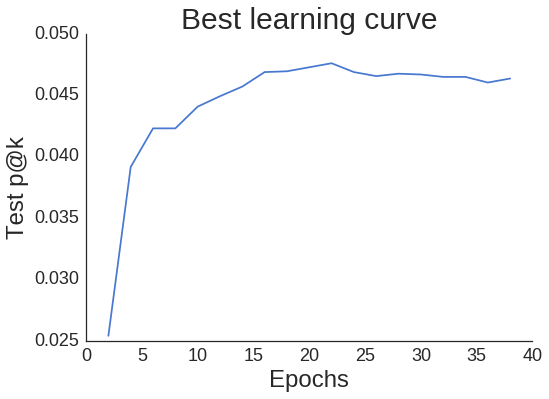

In [25]:
import seaborn as sns
sns.set_style('white')
fig, ax = plt.subplots()
sns.despine(fig);
plt.plot(epochs, best_curves[0]['patk']['test']);
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('Test p@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Best learning curve', fontsize=30);

While the curve is a bit jagged, it does not decrease too significantly as we move past our best epoch of 22. This means we do not have to be super careful implementing early stopping (if we take p@k to be the only metric that we care about).

We can plot all of our learning curves and see that differences in hyperparameters *definitely* make a difference in performance.

In [26]:
all_test_patks = [x['patk']['test'] for x in best_curves]

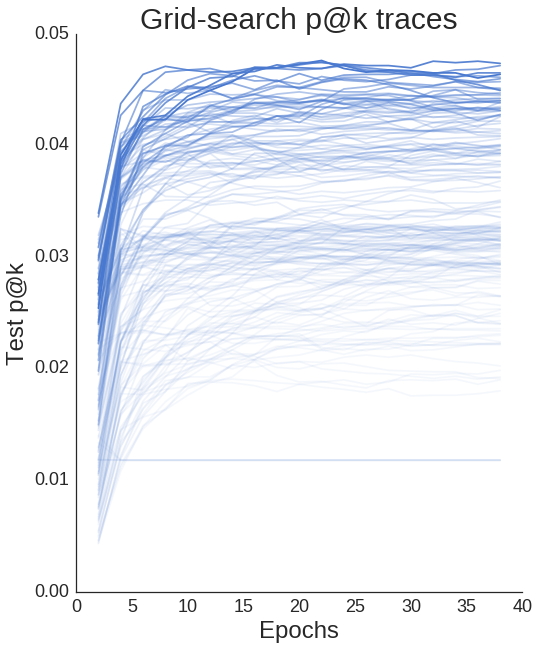

In [27]:
fig, ax = plt.subplots(figsize=(8, 10));
sns.despine(fig);
epochs = range(2, 40, 2)
totes = len(all_test_patks)
for i, test_patk in enumerate(all_test_patks):
    ax.plot(epochs, test_patk,
             alpha=1/(.1*i+1),
             c=sns.color_palette()[0]);
    
plt.xlabel('Epochs', fontsize=24);
plt.ylabel('Test p@k', fontsize=24);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.title('Grid-search p@k traces', fontsize=30);

## Rec-a-sketch

After all that, we finally have some optimal hyperparameters. We could now do a finer grid search or look at how varying the ratio between user and item regularization effects results, but I don't feel like waiting another 2 days...

We'll now train a WRMF model on *all* of our data with the optimal hyper parameters and visualize some item-to-item recommendations. User-to-item recommendations are a bit more difficult to visualize and get a feel for how accurate they may be.

In [28]:
params = best_curves[0]['params']
params['iterations'] = range(2, 40, 2)[best_curves[0]['patk']['test'].index(max_score)]
bestALS = implicit.ALS(**params)

In [29]:
bestALS.fit(likes)

To get item-to-item recommendations, I made a small method ```predict_for_items``` in the ```ALS``` class. This is essentially just a dot product between every combination of item vectors. If you let ```norm=True``` (the default), then this dot product is normalized by the norm of each item vector resulting in the cosine similarity. This tells us how similar two items are in the embedded, or latent space.

```python
    def predict_for_items(self, norm=True):
        """Recommend products for all products"""
        pred = self.item_vectors.dot(self.item_vectors.T)
        if norm:
            norms = np.array([np.sqrt(np.diagonal(pred))])
            pred = pred / norms / norms.T
        return pred
```

In [30]:
item_similarities = bestALS.predict_for_items()

Let's now visualize some of the models and their associated recommendations to get a feel for how well our recommender is working. We can simply query the sketchfab api to grab the models' thumbnails. Below is a helper function, that uses the item similarities, an index, and the index-to-```mid``` mapper to return a list of the recommendations' thumbnail urls. Note that the first recommendation is always the model itself due to it having a cosine similarity of 1 with itself.

In [31]:
import requests
def get_thumbnails(sim, idx, idx_to_mid, N=10):
    row = sim[idx, :]
    thumbs = []
    for x in np.argsort(-row)[:N]:
        response = requests.get('https://sketchfab.com/i/models/{}'.format(idx_to_mid[x])).json()
        thumb = [x['url'] for x in response['thumbnails']['images'] if x['width'] == 200 and x['height']==200]
        if not thumb:
            print('no thumbnail')
        else:
            thumb = thumb[0]
        thumbs.append(thumb)
    return thumbs

In [32]:
thumbs = get_thumbnails(item_similarities, 0, idx_to_mid)

In [33]:
print(thumbs[0])

https://dg5bepmjyhz9h.cloudfront.net/urls/5dcebcfaedbd4e7b8a27bd1ae55f1ac3/dist/thumbnails/a59f9de0148e4986a181483f47826fe0/200x200.jpeg


We can now display the images using some HTML and core ```IPython``` functions.

In [34]:
from IPython.display import display, HTML

def display_thumbs(thumbs, N=5):
    thumb_html = "<img style='width: 160px; margin: 0px; \
                  float: left; border: 1px solid black;' src='{}' />"
    images = ''
    display(HTML('<font size=5>'+'Input Model'+'</font>'))
    display(HTML(thumb_html.format(thumbs[0])))
    display(HTML('<font size=5>'+'Similar Models'+'</font>'))

    for url in thumbs[1:N+1]:
        images += thumb_html.format(url)
    display(HTML(images))

In [35]:
# Select a random index
rand_model = np.random.randint(0, len(idx_to_mid))
display_thumbs(get_thumbnails(item_similarities, rand_model, idx_to_mid))

In [36]:
# Select another random index
rand_model = np.random.randint(0, len(idx_to_mid))
display_thumbs(get_thumbnails(item_similarities, rand_model, idx_to_mid))

In [37]:
# One more for good luck
rand_model = np.random.randint(0, len(idx_to_mid))
display_thumbs(get_thumbnails(item_similarities, rand_model, idx_to_mid))

While the recommendations may not be perfect (see police car + green monster above), it's obvious that our recommendation model has learned similarities.

Take a step back and think about this for a second: 

Our algorithm knows nothing about what these models look like, what tags they may have on them, or anything about the artists. The algorithm simply knows which users have liked which models. Pretty creepy, huh?

## What's next?

Today we learned Weighted Regularized Matrix Factorization, the classic rock of implicit MF. Next time, we'll learn about another method of optimizing implicit feedback models called Learning to Rank. With Learning to Rank models, we'll be able to include extra information about the models and users such as the categories and tags assigned to the models. After that, we'll see how an unsupervised recommendation using images and pretrained neural networks compares to these methods, and then finally we'll build a flask app to serve these recommendations to an end user.

Stay tuned!